In [ ]:
##### Building off of FGSM attack #####
!pip install -U numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 70.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.


In [ ]:
#Loading the model

import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the same CNN model structure as before
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
model = CNN()

# Load the saved model state
model.load_state_dict(torch.load('/content/mnist_cnn.pth', map_location=torch.device('cuda')))
model.eval()  # Set model to evaluation mode

print("Model successfully loaded!")

Model successfully loaded!


In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader


# Load the MNIST dataset again
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
testset = MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=1, shuffle=False) #batch of 1 image loaded


100%|██████████| 9.91M/9.91M [00:00<00:00, 11.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 343kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.05MB/s]



What is an Epsilon-Ball?

Think of an epsilon-ball as a tiny neighborhood around an image where small changes are allowed,
but the image should still look almost the same to the human eye.
Imagine you have a handwritten digit "5" from MNIST.
If we slightly change some pixels,
it might still look like a "5" to you, but the model might start getting confused.
However, if we change too many pixels too much, it might become unrecognizable.

To prevent the attack from making huge changes, we restrict how much each pixel can be modified.
The epsilon-ball defines the maximum amount of allowed perturbation.
It ensures that the adversarial image stays close to the original one.

Taking e= 0.3 for experimenting the first time
alpha: step size for each iteration is often set as epsilon / no. of steps as it ensures :

     1.gradual attack (Instead of making a huge jump in one step, we take small, controlled steps toward fooling the model)
     2.staying within the epsilon ball (if alpha is too big we'll go too far from the original image in very few steps, making the perurbation unrealistic)
     3.gives higher success rates

 number of steps:

  - More steps, Stronger attack, slower attack

  - less steps, weak attack, faster attack


Key Considerations for Choosing num_of_steps(K):

    - Higher num_of_steps makes attacks stronger
        More steps allow the attack to gradually refine perturbations, making adversarial images more effective.
        Typically, larger num_of_steps values  are used for stronger attacks.

    - Too many steps may not improve results much
        At some point, additional steps don’t improve the attack much because the perturbation is already optimal within ϵ.
        Diminishing returns: If the attack is already successful, increasing num_of_steps further wastes computation.

    - Too few steps make the attack weak
        If num_of_steps is too small , the attack may not fully explore the epsilon-ball, making it ineffective.




Madry et al. (2017) "Towards Deep Learning Models Resistant to Adversarial Attacks"

    Used K=40 for MNIST with ϵ=0.3
    Used K=7 for CIFAR-10 with ϵ=8/255
    Found that increasing K beyond a certain point had diminishing returns

Carlini & Wagner (2017) "Adversarial Examples Are Not Easily Detected"

    Showed that increasing K improves attack success up to a point, but too high K leads to computational inefficiency without much
    gain

In [ ]:
num_of_steps = 40
epsilon = 0.3
alpha = epsilon / num_of_steps #step size
random_start = True # boolean to do random initialization
#optional but improves performance.(adding random noise to the vanilla image)
#the starting point is randomized within the ε-ball, which can lead to stronger adversarial examples.
'''
Random start adds a small random noise to the original image, which helps avoid getting stuck in a particular local optimum.
It encourages exploration of different initial perturbations within the ε-ball, often resulting in stronger adversarial examples.
A typical approach is to sample random noise uniformly from [−ε,ε][−ε,ε] and add it to your image before starting the iterative PGD process.
'''

'\nRandom start adds a small random noise to the original image, which helps avoid getting stuck in a particular local optimum.\nIt encourages exploration of different initial perturbations within the ε-ball, often resulting in stronger adversarial examples.\nA typical approach is to sample random noise uniformly from [−ε,ε][−ε,ε] and add it to your image before starting the iterative PGD process.\n'

In [ ]:
dataiter = iter(testloader)
image, label = next(dataiter)

In [ ]:
# Normalisation params
mean= 0.5
std=0.5
min_val = (0.0 - mean) / std  # = -1.0
max_val = (1.0 - mean) / std  # = 1.0

# Scale epsilon and alpha to model's normalized space
# epsilon_scaled = epsilon / std  
# alpha_scaled = alpha / std        

In [ ]:
def pgd_attack(model, image, label, epsilon, alpha, num_of_steps, random_start):

    epsilon_scaled = epsilon / std
    alpha_scaled = alpha / std
    """
    Why Scaling epsilon and alpha is Necessary
    Input Space Mismatch

    Our model was trained on normalized inputs (transformed to mean=0.5, std=0.5).
    Raw pixel perturbations (epsilon=0.3 in [0, 1]) must be scaled to match the model’s expected range.

    Physical Meaning

    Unscaled attack:
        A perturbation of 0.3 in pixel space ([0, 1]) is only 0.06 in normalized space ([-1, 1]).
        Result: The attack is 2× weaker than intended.
    Scaled attack:
        Ensures epsilon=0.3 covers the same relative distortion in both pixel and normalized spaces.
    """

    if random_start:
      noise = torch.empty_like(image).uniform_(-epsilon_scaled,epsilon_scaled)
      adv_image = image + noise
    else:
      adv_image = image.clone()
    '''
    torch.empty_like(image): Creates a new tensor with the same shape and data type as image but without initializing its values.
    .uniform_(-epsilon_scaled, epsilon_sclaed): Fills that tensor in-place with random numbers sampled uniformly between −epsilon_scaled and epsilon_scaled.
    '''

    for _ in range(num_of_steps):
      adv_image.requires_grad = True
      output = model(adv_image) #forward pass
      #finding loss
      lossfn = nn.CrossEntropyLoss()
      loss = lossfn(output, label)
      #backward pass
      loss.backward()
      #finding gradient
      grad = adv_image.grad
      adv_image = adv_image + (alpha_scaled * grad.sign()) # updating the adversarial image by moving it in the direction of the gradient
      # need to ensure epislon bound
      # clip the perturbation (must ensure that this difference does not exceed + or - epsilon for each pixel)
      perturbation = torch.clamp(adv_image - image, -epsilon_scaled, epsilon_scaled)
      # reconstruct the image
      adv_image = image + perturbation
      adv_image = torch.clamp(adv_image, min_val, max_val)

      # Detach and reset gradients for the next iteration
      adv_image = adv_image.detach()
      adv_image.grad = None

    return adv_image




In [ ]:
adversarial_output = pgd_attack(model, image, label, epsilon, alpha, num_of_steps, random_start)

In [ ]:
#adversarial_output = model(adv_image)
predicted_label = torch.argmax(adversarial_output)
print("Predicted Label:", predicted_label.item())
print("Original Label:", label.item())

Predicted Label: 230
Original Label: 7


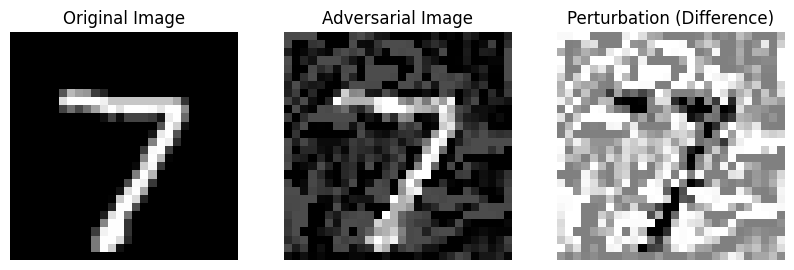

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert images from tensor to numpy
orig_image_np = image.squeeze().detach().cpu().numpy()  # Remove batch & move to CPU
adv_image_np = adversarial_output.squeeze().detach().cpu().numpy()  # Same for adversarial image
perturbation = adv_image_np - orig_image_np  # Compute the actual noise

# Plot all three: Original, Adversarial, Perturbation
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes[0].imshow(orig_image_np, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(adv_image_np, cmap="gray")
axes[1].set_title("Adversarial Image")
axes[1].axis("off")

axes[2].imshow(perturbation, cmap="gray")
axes[2].set_title("Perturbation (Difference)")
axes[2].axis("off")

plt.show()

In [ ]:
# This was just one example, now, Ill try to make the test set PGD adversarial and see how the performance drops

adv_examples = []  # Store adversarial images
true_labels = []   # Store true labels
num_of_steps = 40
random_start = True # boolean to do random initialization

#strength of the perturbation
#epsilon = 0.1
#epsilon = 0.2
epsilon = 0.3
alpha = epsilon / num_of_steps #step size


testloader2 = DataLoader(testset, batch_size=64, shuffle=False) #loading 64 imgs in a batch
# Getting test images
dataiter = iter(testloader2)
images, labels = next(dataiter)

# Loop through all test batches
for images, labels in testloader2:
  adv_images = pgd_attack(model, images, labels, epsilon, alpha, num_of_steps, random_start)
  adv_examples.append(adv_images)
  true_labels.append(labels.detach())

adv_examples = torch.cat(adv_examples, dim=0)
true_labels = torch.cat(true_labels, dim=0)

In [ ]:
print("Generated adversarial dataset shape:", adv_examples.shape)

Generated adversarial dataset shape: torch.Size([10000, 1, 28, 28])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Wrap adversarial examples and labels in a dataset
adv_dataset = TensorDataset(adv_examples, true_labels)

# Create DataLoader for adversarial examples
adv_testloader = DataLoader(adv_dataset, batch_size=64, shuffle=False)

In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for images, labels in adv_testloader:
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy_adv = 100 * correct / total
print(f'Accuracy of the model on the adversarial test set: {accuracy_adv:.2f}%')

Accuracy of the model on the adversarial test set: 0.09%


In [ ]:
################### The attack is very powerful, testing with all epsilons #############################

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

epsilon_list = [0.1,0.2,0.3]
accuracies = []
num_of_steps = 40
random_start = True


for i in epsilon_list:

  adv_examples = []  # Store adversarial images
  true_labels = []   # Store true labels

  #strength of the perturbation
  epsilon = i
  alpha = (epsilon / num_of_steps)  #step size
  testloader = DataLoader(testset, batch_size=64, shuffle=False) #loading 64 imgs in a batch

  # Loop through all test batches
  for images, labels in testloader:
    adv_images = pgd_attack(model, images, labels, epsilon, alpha, num_of_steps, random_start)
    adv_examples.append(adv_images)
    true_labels.append(labels.detach())

  adv_examples = torch.cat(adv_examples, dim=0)
  true_labels = torch.cat(true_labels, dim=0)

  # Wrap adversarial examples and labels in a dataset
  adv_dataset2 = TensorDataset(adv_examples, true_labels)

  # Create DataLoader for adversarial examples
  adv_testloader = DataLoader(adv_dataset2, batch_size=64, shuffle=False)
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in adv_testloader:
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy_adv = 100 * correct / total
  print(f'Accuracy of the model on the adversarial test set with epsilon = {epsilon}: {accuracy_adv:.2f}%')
  accuracies.append(accuracy_adv)

Accuracy of the model on the adversarial test set with epsilon = 0.1: 83.25%
Accuracy of the model on the adversarial test set with epsilon = 0.2: 16.99%
Accuracy of the model on the adversarial test set with epsilon = 0.3: 0.06%


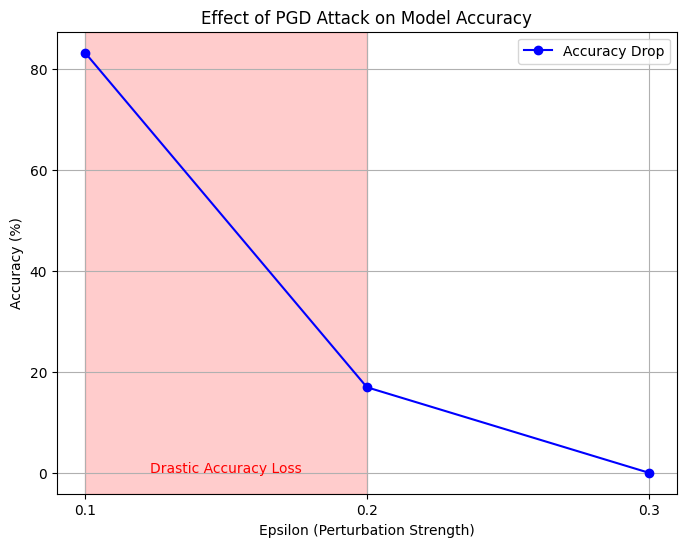

In [ ]:
import matplotlib.pyplot as plt

# Epsilon values and corresponding accuracy from your results
#epsilons = [0.1, 0.2, 0.3]
#accuracies = [84.40, 20.67, 0.15]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(epsilon_list, accuracies, marker='o', linestyle='-', color='b', label="Accuracy Drop")

# Labels and Title
plt.xlabel("Epsilon (Perturbation Strength)")
plt.ylabel("Accuracy (%)")
plt.title("Effect of PGD Attack on Model Accuracy")
plt.xticks(epsilon_list)
plt.grid(True)
plt.legend()

# Highlight distortion region (using a shaded region)
plt.axvspan(0.1, 0.2, color='red', alpha=0.2, label="Drastic Accuracy Drop")
plt.text(0.15, 1, 'Drastic Accuracy Loss', color='red', ha='center', va='center')

# Display the plot
plt.show()

'\n    The image should look visibly perturbed (e.g., noisy or distorted) but still recognizable as a digit.\n'

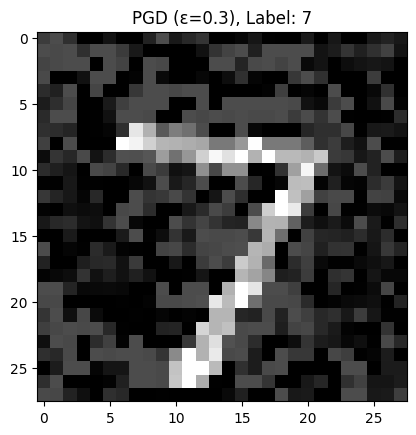

In [ ]:
# Verification
# Visual
# Denormalize and plot an adversarial example (ε=0.3)
adv_example = adv_examples[0].cpu() * 0.5 + 0.5  # Denormalize to [0, 1]
plt.imshow(adv_example.squeeze(), cmap='gray')
plt.title(f"PGD (ε=0.3), Label: {true_labels[0].item()}")

"""
    The image should look visibly perturbed (e.g., noisy or distorted) but still recognizable as a digit.
"""

In [ ]:
#### PGD implemented successfully!